In [96]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import string
from matplotlib.cm import ScalarMappable
plt.rcParams.update({'font.size': 18})  # or any size you want

In [114]:
# --- Load data ---
data = np.load("results.npy", allow_pickle=True)
name = "baseline"  # for ablation on saturation
method = "spring_multi_mass"
mn = [
    ("spring_multi_mass", "spring_chain"),
    ("spring_multi_mass", "default"),
    ("spring_multi_mass", "baseline"),
    ("ball", "affine"),
    ("ball", "default"),
    ("motor", "baseline"),
    ("motor", "affine"),
    ("spring", "default"),
    ("spring", "affine"),
    ("spring", "baseline"),
    (f"{method}_4", name),
    (f"{method}_16", name),
    (f"{method}_64", name)
]
MM = {
    "spring_chain": "Sparse",
    "default": "Port-Hamilton",
    "baseline": "General",
    "affine": "Input-Affine",
}
DD = {
    "spring_multi_mass": "Spring-Chain",
    "spring": "Spring",
    "motor": "Motor",
    "ball": "Ball",
    rf"{method}_4": "Spring-Chain capped at 4",
    rf"{method}_16": "Spring-Chain capped at 16",
    rf"{method}_64": "Spring-Chain capped at 64"
}
idxs = [
    0, 1, 2, 3, 2, 4, 1, 2, 0, 4, 2, 2, 2
]
bounds = [1e10, 1e10, 1e10, 1e7, 1e8, 1e7, 5e7, 1e8, 1e6, 5e8, 1e10, 1e10, 1e10]  # bounded data regime means that the scaling law can only be valid in a certain territory
modes = 2*["two_phase"] + 8 * ["capped"] + 3 * ["saturated"] + ["capped"]
C_fits = []
M_fits = []
C_fits_mse = []
MS_fits = []
C_fits_acc = []
A_fits = []
params_maes = []
params_mses = []
params_accs = []
data = data.item()

threshs = [2, 4, 8, 16, 32, 64, 128]
for thresh in threshs:
    trajectories = data[fr"traj_{name}_{method}"]
    idx = trajectories <= thresh
    for key in ["traj", "mae", "mse", "acc", "compute", "sizes"]:
        data[f"{key}_{name}_{method+'_'+str(thresh)}"] = data[f"{key}_{name}_{method}"].copy()[idx]
for i, (method, name) in enumerate(mn):  #wrongly labeled

    mae = data[f"mae_{name}_{method}"]
    mse = data[f"mse_{name}_{method}"]
    accurate_time = data[f"acc_{name}_{method}"][:, idxs[i]]
    compute = data[f"compute_{name}_{method}"]
    trajectories = data[f"traj_{name}_{method}"]
    sizes = data[f"sizes_{name}_{method}"]
    compute *= sizes**2
    mode = modes[i]

    idx = compute <= bounds[i]
    mae = mae[idx]
    mse = mse[idx]
    accurate_time = accurate_time[idx]
    compute = compute[idx]
    trajectories = trajectories[idx]
    sizes = sizes[idx]

    data[f"mae_{name}_{method}"] = mae
    data[f"mse_{name}_{method}"] = mse
    data[f"acc_{name}_{method}"] = accurate_time
    data[f"compute_{name}_{method}"] = compute
    data[f"traj_{name}_{method}"] = trajectories
    data[f"sizes_{name}_{method}"] = sizes

    def fit_compute(compute, mae, mse, accurate_time, mode="capped"):
        def filter(compute, metric, descending=True):
            idx = np.argsort(compute)
            c = compute[idx]
            m = metric[idx]
            out = [(c[0], m[0])]
            for i in range(1, len(c)):
                criterion = m[i] < out[-1][1] if descending else m[i] > out[-1][1]
                if criterion and c[i]:
                    out.append([c[i], m[i]])
            c = np.array(out)[:, 0]
            m = np.array(out)[:, 1]
            return c, m

        def mae_scaling(C_raw, M_raw):
            C, M = filter(C_raw, M_raw)
            C = np.log10(C)
            M = np.log10(M)

            def scaling_law_saturated(C, a, b, c, d):
                return np.log10(a + b * (10**C + c)**d)

            def scaling_law_capped(C, a, b, c, d):
                return np.log10(0 + b * (10**C + c)**d)

            def scaling_law_two_phase(C, a, b, c, d, e, f, g):
                return np.log10(a + b * (10**C + c)**d * (1 + (10**C / e)**(1/f))**(f*g))


            if mode == "capped":
                scaling_law = scaling_law_capped
            elif mode == "saturated":
                scaling_law = scaling_law_saturated
            elif mode == "two_phase":
                scaling_law = scaling_law_two_phase
            else:
                raise ValueError("Unknown mode")

            if mode == "two_phase":
                p0 = [0, 1.0, 1.0, -1.0, 1, 1, 1]
                bounds = ([-1e-10, 1e-10, 0, -6, 0, 0, 0], [np.inf, np.inf, np.inf, -0.3, np.inf, np.inf, np.inf])
            else:
                p0 = [0, 1.0, 1.0, -1.0]
                bounds = ([-1e-10, 1e-10, 0, -6], [np.inf, np.inf, np.inf, -0.3])

            log_C = np.log(C)
            log_C = (log_C - np.min(log_C)) / (np.max(log_C) - np.min(log_C))
            sigma = 0.1 + log_C
            params, _ = curve_fit(
                scaling_law, C, M,
                p0=p0,
                sigma=sigma,
                bounds=bounds,
                maxfev=50000
            )
            C_fit = np.linspace(min(C), max(np.log10(C_raw)), 500)
            if mode == "two_phase":
                a, b, c, d, e, f, g = params
                M_fit = scaling_law(C_fit, a, b, c, d, e, f, g)
                params = [a, b, c, d]
            else:
                a, b, c, d = params
                M_fit = scaling_law(C_fit, a, b, c, d)

            return 10**C, 10**M, 10**C_fit, 10**M_fit, params

        def acc_scaling(C_raw, A):
            C, A = filter(C_raw, A, descending=False)
            C = np.log10(C)

            def acc_law(C, a, b, c, d, e):
                logistic = a / (1 + b * (10**C + c)**(-d))
                return np.maximum(0, logistic - e)

            # Safe initial guesses
            a0 = np.max(A)
            b0 = 1.0
            c0 = 1.0
            d0 = 1.0
            e0 = np.min(A) * 0.9
            p0 = [a0, b0, c0, d0, e0]

            # Bounds for stability
            bounds = (
                [0, 1e-6, 0, 0.1, 0],       # lower bounds: all positive, d > 0 to ensure growth
                [10*a0, 1e3, 1e6, 10, a0]   # upper bounds
            )

            log_C = np.log(C)
            log_C = (log_C - np.min(log_C)) / (np.max(log_C) - np.min(log_C))
            sigma = 0.1 + 1 * log_C

            params, _ = curve_fit(
                acc_law, C, A,
                p0=p0,
                bounds=bounds,
                sigma=sigma,
                loss='soft_l1',
                f_scale=0.1,
                maxfev=100000
            )
            a, b, c, d, e = params

            C_fit = np.linspace(min(C), max(C), 500)
            A_fit = acc_law(C_fit, a, b, c, d, e)
            return 10**C, A, 10**C_fit, A_fit, params

        C_mae, M_mae, C_fit, M_fit, params_mae = mae_scaling(compute, mae)
        C_mse, M_mse, C_fit_mse, M_fit_mse, params_mse = mae_scaling(compute, mse)
        C_acc, A_acc, C_fit_acc, A_fit, params_acc = acc_scaling(compute, accurate_time)
        return C_fit, M_fit, C_fit_mse, M_fit_mse, C_fit_acc, A_fit, params_mae, params_mse, params_acc

    C_fit, M_fit, C_fit_mse, M_fit_mse, C_fit_acc, A_fit, params_mae, params_mse, params_acc = fit_compute(compute, mae, mse, accurate_time, mode=mode)

    C_fits.append(C_fit)
    M_fits.append(M_fit)

    C_fits_mse.append(C_fit_mse)
    MS_fits.append(M_fit_mse)

    C_fits_acc.append(C_fit_acc)
    A_fits.append(A_fit)

    params_maes.append(np.array(params_mae))
    params_accs.append(np.array(params_acc))
    params_mses.append(np.array(params_mse))

C_fits = np.stack(C_fits)
M_fits = np.stack(M_fits)

C_fits_mse = np.stack(C_fits_mse)
MS_fits = np.stack(MS_fits)

C_fits_acc = np.stack(C_fits_acc)
A_fits = np.stack(A_fits)

params_maes = np.stack(params_maes)
params_accs = np.stack(params_accs)
params_mses = np.stack(params_mses)

/tmp/ipykernel_3637884/3742970008.py:109: RuntimeWarning: overflow encountered in power
  return np.log10(a + b * (10**C + c)**d * (1 + (10**C / e)**(1/f))**(f*g))


'figures/color_size_key.png'

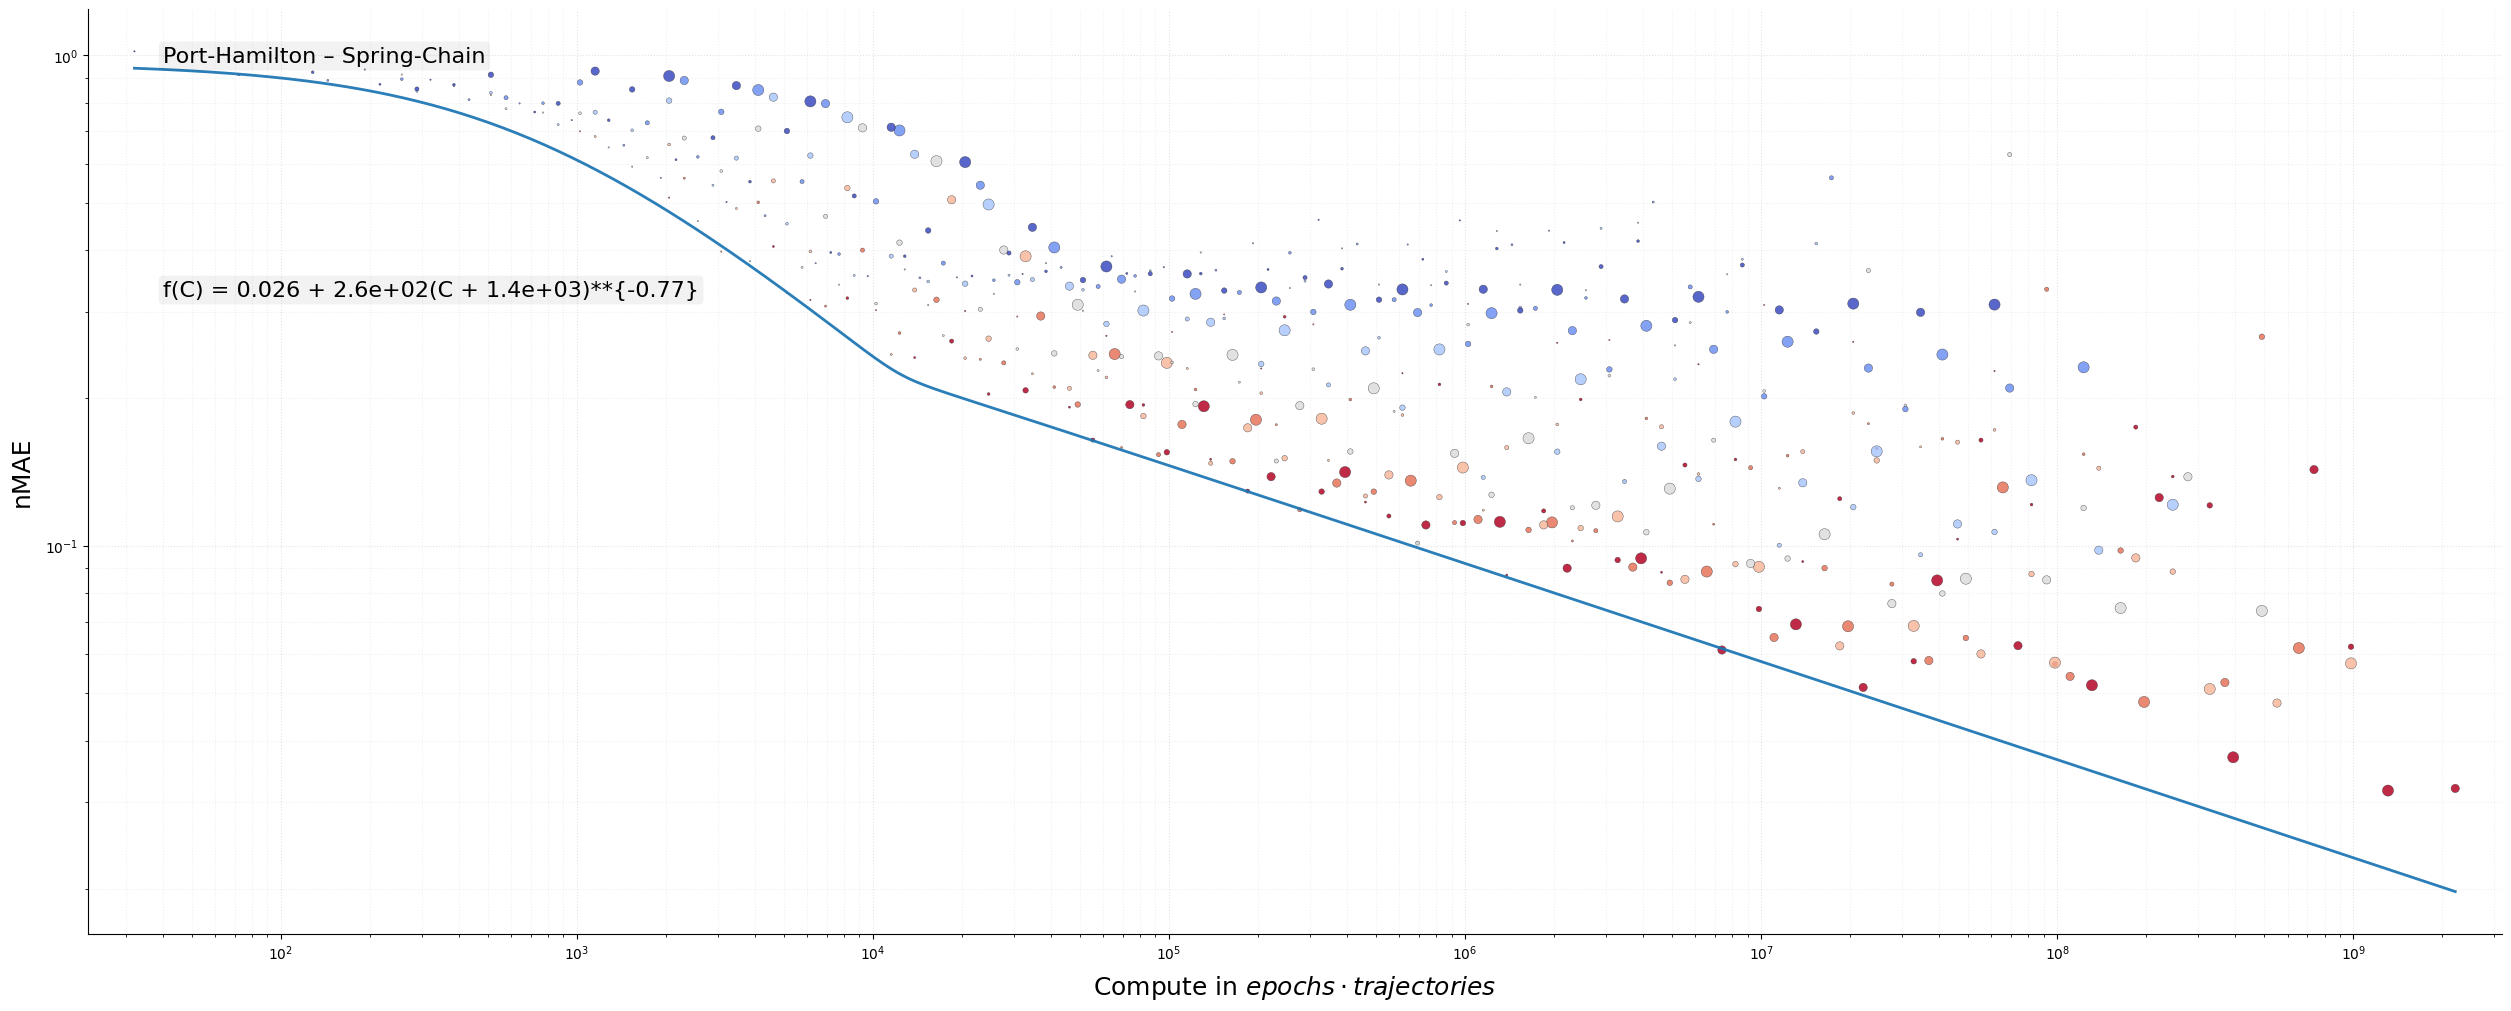

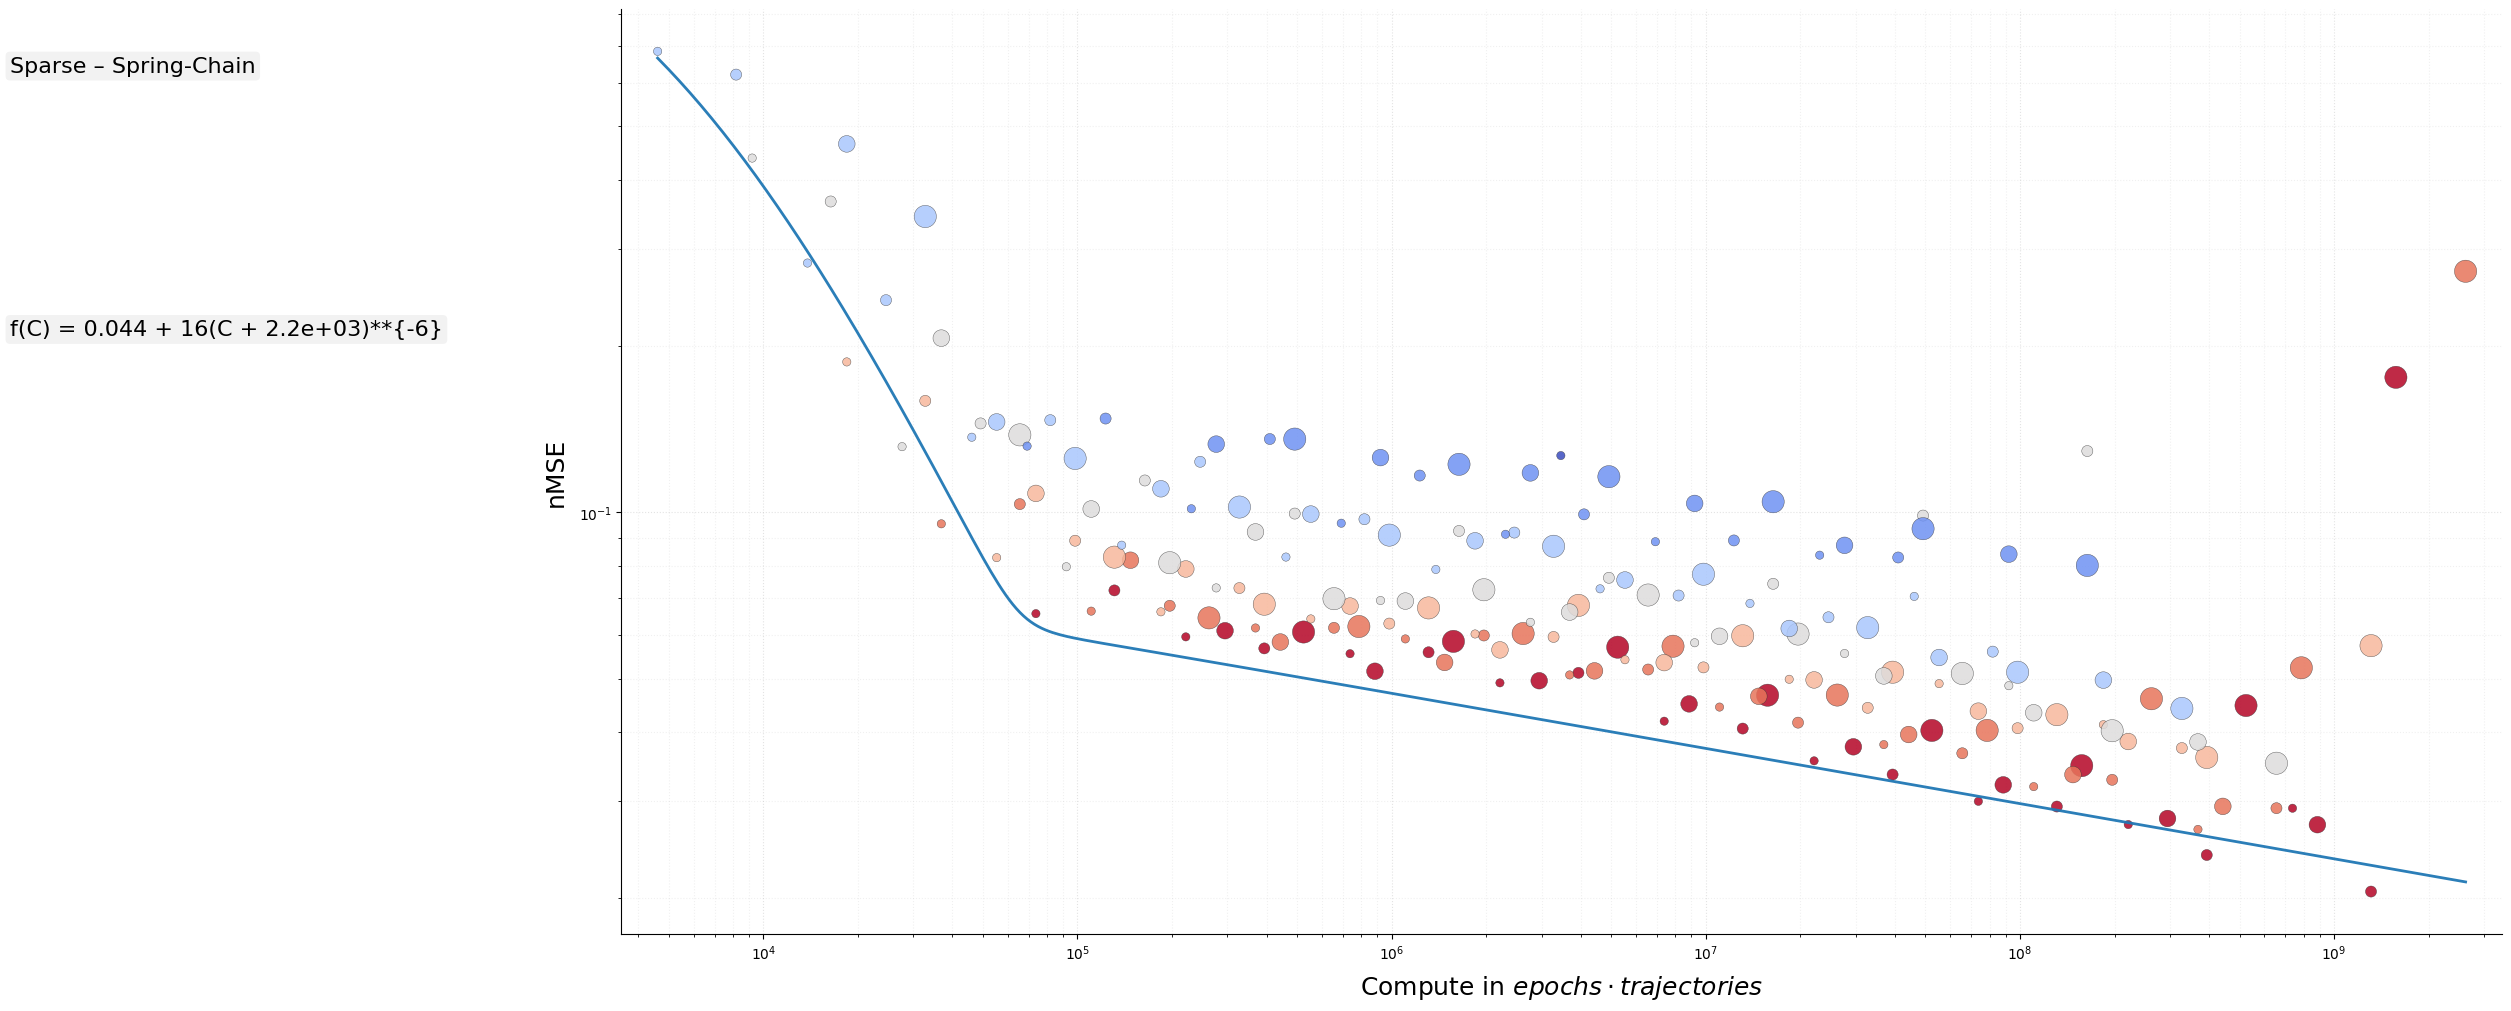

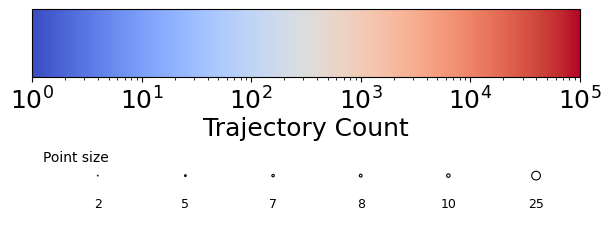

In [212]:

def mae_examples_single(data, mn, C, M, params, metric="mse",
                        xmax=1e10, outfile=None):
    # ---- data
    compute = np.asarray(data[f"compute_{mn[1]}_{mn[0]}"], float)
    err     = np.asarray(data[f"{metric}_{mn[1]}_{mn[0]}"], float)
    traj    = np.asarray(data[f"traj_{mn[1]}_{mn[0]}"], float)
    sizes   = np.asarray(data[f"sizes_{mn[1]}_{mn[0]}"], float)

    # valid mask
    m = np.isfinite(compute) & np.isfinite(err) & np.isfinite(traj) & np.isfinite(sizes)
    m &= (compute > 0) & (err > 0) & (traj > 0) & (sizes > 0) & (compute < xmax)
    compute, err, traj, sizes = [x[m] for x in (compute, err, traj, sizes)]

    vmin, vmax = float(traj.min()), float(traj.max())

    # ---- style/figure
    fig, ax = plt.subplots(figsize=(25, 10), constrained_layout=True)

    # de-spine
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # grid: major + minor, subtle
    ax.grid(True, which="major", linestyle=":", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", alpha=0.18)

    # ticks: clean powers of 10
    ax.set_xscale("log")
    ax.set_yscale("log")
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_major_locator(LogLocator(base=10))
        axis.set_major_formatter(LogFormatterMathtext(base=10))
        axis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)*0.1))
        axis.set_minor_formatter(mpl.ticker.NullFormatter())

    # labels
    ax.set_xlabel(r"Compute in $epochs \cdot trajectories$", labelpad=8)
    ax.set_ylabel("nMSE" if metric == "mse" else "nMAE", labelpad=8)
    ax.set_xmargin(0.02)
    ax.set_ymargin(0.05)
    ax.tick_params(which="both", labelsize=10)

    # ---- scatter (same color/size mapping as your original)
    sc = ax.scatter(
        compute, err,
        c=traj,
        s=(sizes**2)/16.0,
        cmap="coolwarm",
        norm=LogNorm(vmin=vmin, vmax=vmax),
        edgecolors="0.2",
        linewidths=0.3,
        alpha=0.85,
        rasterized=True,   # smaller PDFs without losing vector axes
        zorder=2
    )

    # ---- fit curve
    line, = ax.plot(C, M, lw=2.0, alpha=0.95, zorder=3, label="fit")

    # ---- small annotation: title + slope
    a, b, c_, d = params

    def sf(x):
        return f"{x:.2g}"
    # place slope label near the right third of the fit
    x = 40; y = 10 * np.min(err)
    formula = rf"f(C) = {sf(a)} + {sf(b)}(C + {sf(c_)})**{{{sf(d)}}}"  #rf"$\sim C^{{{d:.2g}}}$"
    ax.text(x, y, formula,
            fontsize=16, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc=(0,0,0,0.05), ec="none"))
    ax.text(x, 3 * y, "{} – {}".format(MM[mn[1]], DD[mn[0]]),
            fontsize=16, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc=(0,0,0,0.05), ec="none"))
    # optional legend (only if you want to name the fit)
    # ax.legend(frameon=False, loc="lower left")

    # limits
    #ax.set_xlim(left=compute.min()*0.9, right=xmax)
    #ax.set_ylim(bottom=err.min()*0.8, top=err.max()*1.5)

    # save
    outfile = outfile or f"figures/{metric}_examples_single.jpg"
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    return outfile

def make_color_and_size_key(
    vmin, vmax, sizes,
    cmap="coolwarm",
    color_label="Trajectory Count",
    size_label="Point size",
    outfile="figures/color_size_key.png",
    reps=None,                # <- pass specific sizes to show
    show_all=False,           # <- convenience flag
    max_cols=8,               # wrap to multiple rows if many sizes
    area_map=lambda s: (s**2)/16.0,  # same mapping as main plot
):
    """Create a compact figure with a horizontal log colorbar and a size legend."""
    sizes = np.asarray(sizes, float)
    sizes = sizes[np.isfinite(sizes) & (sizes > 0)]
    if sizes.size == 0:
        raise ValueError("No valid sizes to make a size legend.")

    # Determine which sizes to display
    if reps is not None:
        reps = np.asarray(reps, float)
    elif show_all or np.unique(sizes).size <= 12:
        reps = np.unique(np.sort(sizes))
    else:
        # fallback: evenly spaced quantiles (6 values max)
        qs = np.linspace(0.05, 0.95, 6)
        reps = np.unique(np.quantile(sizes, qs))

    n = len(reps)
    cols = min(max_cols, n)
    rows = int(np.ceil(n / cols))

    # Figure size scales with number of rows/cols
    fig_w = 1.2 + 0.8 * cols
    fig_h = 1.4 + 0.75 * rows
    fig = plt.figure(figsize=(fig_w, fig_h), constrained_layout=True)
    gs = fig.add_gridspec(nrows=rows + 1, ncols=1, height_ratios=[1] + [1] * rows)

    # --- Horizontal colorbar
    ax_cb = fig.add_subplot(gs[0, 0])
    sm = mpl.cm.ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=ax_cb, orientation="horizontal")
    cbar.set_label(color_label, labelpad=2)
    cbar.locator = LogLocator(base=10)
    cbar.formatter = LogFormatterMathtext(base=10)
    cbar.update_ticks()

    # --- Size legend
    for r in range(rows):
        ax_sz = fig.add_subplot(gs[r + 1, 0])
        ax_sz.set_axis_off()
        i0, i1 = r * cols, min((r + 1) * cols, n)
        reps_row = reps[i0:i1]
        x = np.linspace(0.12, 0.92, len(reps_row))
        y = np.full_like(x, 0.6)

        ax_sz.scatter(x, y, s=area_map(reps_row),
                      facecolors="none", edgecolors="k", linewidths=0.8)
        # labels under each marker
        for xi, s in zip(x, reps_row):
            lbl = f"{int(s)}" if abs(s - round(s)) < 1e-6 else f"{s:g}"
            ax_sz.text(xi, 0.28, lbl, ha="center", va="top", fontsize=9)

        # row title only on first row
        if r == 0:
            ax_sz.text(0.02, 0.98, size_label, ha="left", va="top", fontsize=10)

        ax_sz.set_xlim(0, 1)
        ax_sz.set_ylim(0, 1)

    fig.savefig(outfile, dpi=200, bbox_inches="tight")
    return outfile
j =  1
i = 0
#  mae_examples_single(data, mn[j], C_fits[j], MS_fits[j], params_mses[j], metric="mse")
a = 0.
bias=675
b = 25
c0 = 0.5
d1= 13000
f1 = 0.1
c1 = -0.3
M = (a + b * (C_fits[j] + bias)**(-c0) * (1 + ((C_fits[j] + bias)/d1)**(1/f1))**(-c1*f1))
mae_examples_single(data, mn[j], C_fits[j], M, params_maes[j], metric="mae")

a = 0.
bias=5000
b = 40000
c0 = 1.2
d1= 70000
f1 = 0.1
c1 = -1.1
M = (a + b * (C_fits[i] + bias)**(-c0) * (1 + ((C_fits[i] + bias)/d1)**(1/f1))**(-c1*f1))
mae_examples_single(data, mn[i], C_fits[i], M, params_mses[i], metric="mse")


make_color_and_size_key(
    vmin=1, vmax=10**5,
    sizes=[2, 5, 7, 8, 10, 25],
    cmap="coolwarm",
    color_label="Trajectory Count",
    size_label="Point size",
    outfile="figures/color_size_key.png",
    show_all=True,            # or reps=[2,5,7,8,10,25]
)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

'figures/acc_examples_single.jpg'

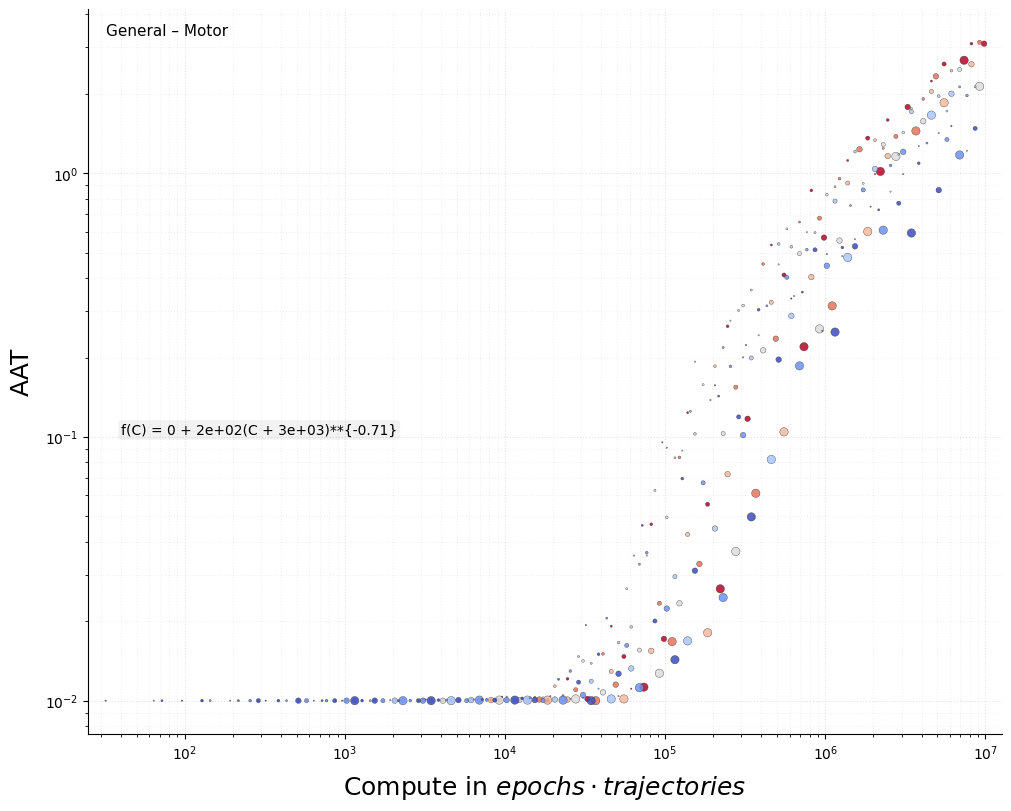

In [100]:
def acc_examples_single(data, mn, C, A, params,
                        xmax=1e10, outfile=None):
    # ---- data
    compute = np.asarray(data[f"compute_{mn[1]}_{mn[0]}"], float)
    acc     = np.asarray(data[f"acc_{mn[1]}_{mn[0]}"], float)
    traj    = np.asarray(data[f"traj_{mn[1]}_{mn[0]}"], float)
    sizes   = np.asarray(data[f"sizes_{mn[1]}_{mn[0]}"], float)


    vmin, vmax = float(traj.min()), float(traj.max())

    # ---- style/figure
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

    # de-spine
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # grid: major + minor, subtle
    ax.grid(True, which="major", linestyle=":", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", alpha=0.18)

    # ticks: clean powers of 10
    ax.set_xscale("log")
    ax.set_yscale("log")
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_major_locator(LogLocator(base=10))
        axis.set_major_formatter(LogFormatterMathtext(base=10))
        axis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)*0.1))
        axis.set_minor_formatter(mpl.ticker.NullFormatter())

    # labels
    ax.set_xlabel(r"Compute in $epochs \cdot trajectories$", labelpad=8)
    ax.set_ylabel("AAT", labelpad=8)
    ax.set_xmargin(0.02)
    ax.set_ymargin(0.05)
    ax.tick_params(which="both", labelsize=10)

    # ---- scatter (same color/size mapping as your original)
    sc = ax.scatter(
        compute, acc,
        c=traj,
        s=(sizes**2)/16.0,
        cmap="coolwarm",
        norm=LogNorm(vmin=vmin, vmax=vmax),
        edgecolors="0.2",
        linewidths=0.3,
        alpha=0.85,
        rasterized=True,   # smaller PDFs without losing vector axes
        zorder=2
    )

    # ---- fit curve
    line, = ax.plot(C, A, lw=2.0, alpha=0.95, zorder=3, label="fit")

    # ---- small annotation: title + slope
    a, b, c_, d = params
    ax.text(0.02, 0.98, "{} – {}".format(MM[mn[1]], DD[mn[0]]),
            transform=ax.transAxes, ha="left", va="top", fontsize=11)
    def sf(x):
        return f"{x:.2g}"
    # place slope label near the right third of the fit
    xi = 40; yi = 10 * np.min(acc)
    formula = rf"f(C) = {sf(a)} + {sf(b)}(C + {sf(c_)})**{{{sf(d)}}}"  #rf"$\sim C^{{{d:.2g}}}$"
    ax.text(xi, yi, formula,
            fontsize=10, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc=(0,0,0,0.05), ec="none"))

    # optional legend (only if you want to name the fit)
    # ax.legend(frameon=False, loc="lower left")

    # limits
    #ax.set_xlim(left=compute.min()*0.9, right=xmax)
    #ax.set_ylim(bottom=err.min()*0.8, top=err.max()*1.5)

    # save
    outfile = outfile or f"figures/acc_examples_single.jpg"
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    return outfile
j = 5
print(A_fits[j])
acc_examples_single(data, mn[j], C_fits[j], A_fits[j], params_maes[j])


In [98]:
def mae_examples_single(data, mn, Cs, Ms, params, metric="mse",
                        xmax=1e10, outfile=None):
    # ---- data
    compute = np.asarray(data[f"compute_{mn[1]}_{mn[0]}"], float)
    err     = np.asarray(data[f"{metric}_{mn[1]}_{mn[0]}"], float)
    traj    = np.asarray(data[f"traj_{mn[1]}_{mn[0]}"], float)
    sizes   = np.asarray(data[f"sizes_{mn[1]}_{mn[0]}"], float)

    # valid mask
    m = np.isfinite(compute) & np.isfinite(err) & np.isfinite(traj) & np.isfinite(sizes)
    m &= (compute > 0) & (err > 0) & (traj > 0) & (sizes > 0) & (compute < xmax)
    compute, err, traj, sizes = [x[m] for x in (compute, err, traj, sizes)]

    vmin, vmax = float(traj.min()), float(traj.max())

    # ---- style/figure
    fig, ax = plt.subplots(figsize=(25, 10), constrained_layout=True)

    # de-spine
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # grid: major + minor, subtle
    ax.grid(True, which="major", linestyle=":", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", alpha=0.18)

    # ticks: clean powers of 10
    ax.set_xscale("log")
    ax.set_yscale("log")
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_major_locator(LogLocator(base=10))
        axis.set_major_formatter(LogFormatterMathtext(base=10))
        axis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)*0.1))
        axis.set_minor_formatter(mpl.ticker.NullFormatter())

    # labels
    ax.set_xlabel(r"Compute in $epochs \cdot trajectories$", labelpad=8)
    ax.set_ylabel("nMSE" if metric == "mse" else "nMAE", labelpad=8)
    ax.set_xmargin(0.02)
    ax.set_ymargin(0.05)
    ax.tick_params(which="both", labelsize=10)

    # ---- scatter (same color/size mapping as your original)
    sc = ax.scatter(
        compute, err,
        c=traj,
        s=(sizes**2)/16.0,
        cmap="coolwarm",
        norm=LogNorm(vmin=vmin, vmax=vmax),
        edgecolors="0.2",
        linewidths=0.3,
        alpha=0.85,
        rasterized=True,   # smaller PDFs without losing vector axes
        zorder=2
    )

    for C, M in zip(Cs, Ms):
        line, = ax.plot(C, M, lw=2.0, alpha=0.95, zorder=3, label="fit")

    # ---- small annotation: title + slope
    a, b, c_, d = params

    def sf(x):
        return f"{x:.2g}"
    # place slope label near the right third of the fit
    x = 40; y = 10 * np.min(err)
    formula = rf"f(C) = {sf(a)} + {sf(b)}(C + {sf(c_)})**{{{sf(d)}}}"  #rf"$\sim C^{{{d:.2g}}}$"
    ax.text(x, y, formula,
            fontsize=16, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc=(0,0,0,0.05), ec="none"))
    ax.text(x, 3 * y, "{} – {}".format(MM[mn[1]], DD[mn[0]]),
            fontsize=16, ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc=(0,0,0,0.05), ec="none"))
    # optional legend (only if you want to name the fit)
    # ax.legend(frameon=False, loc="lower left")

    # limits
    #ax.set_xlim(left=compute.min()*0.9, right=xmax)
    #ax.set_ylim(bottom=err.min()*0.8, top=err.max()*1.5)

    # save
    outfile = outfile or f"figures/{metric}_examples_single.jpg"
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    return outfile
i = 2
mae_examples_single(data, mn[i],
                    [C_fits[10], C_fits[11], C_fits[12], C_fits[13]],
                    [MS_fits[10], MS_fits[11], MS_fits[12], MS_fits[13]],
                    params_mses[i], metric="mse")


IndexError: index 13 is out of bounds for axis 0 with size 13

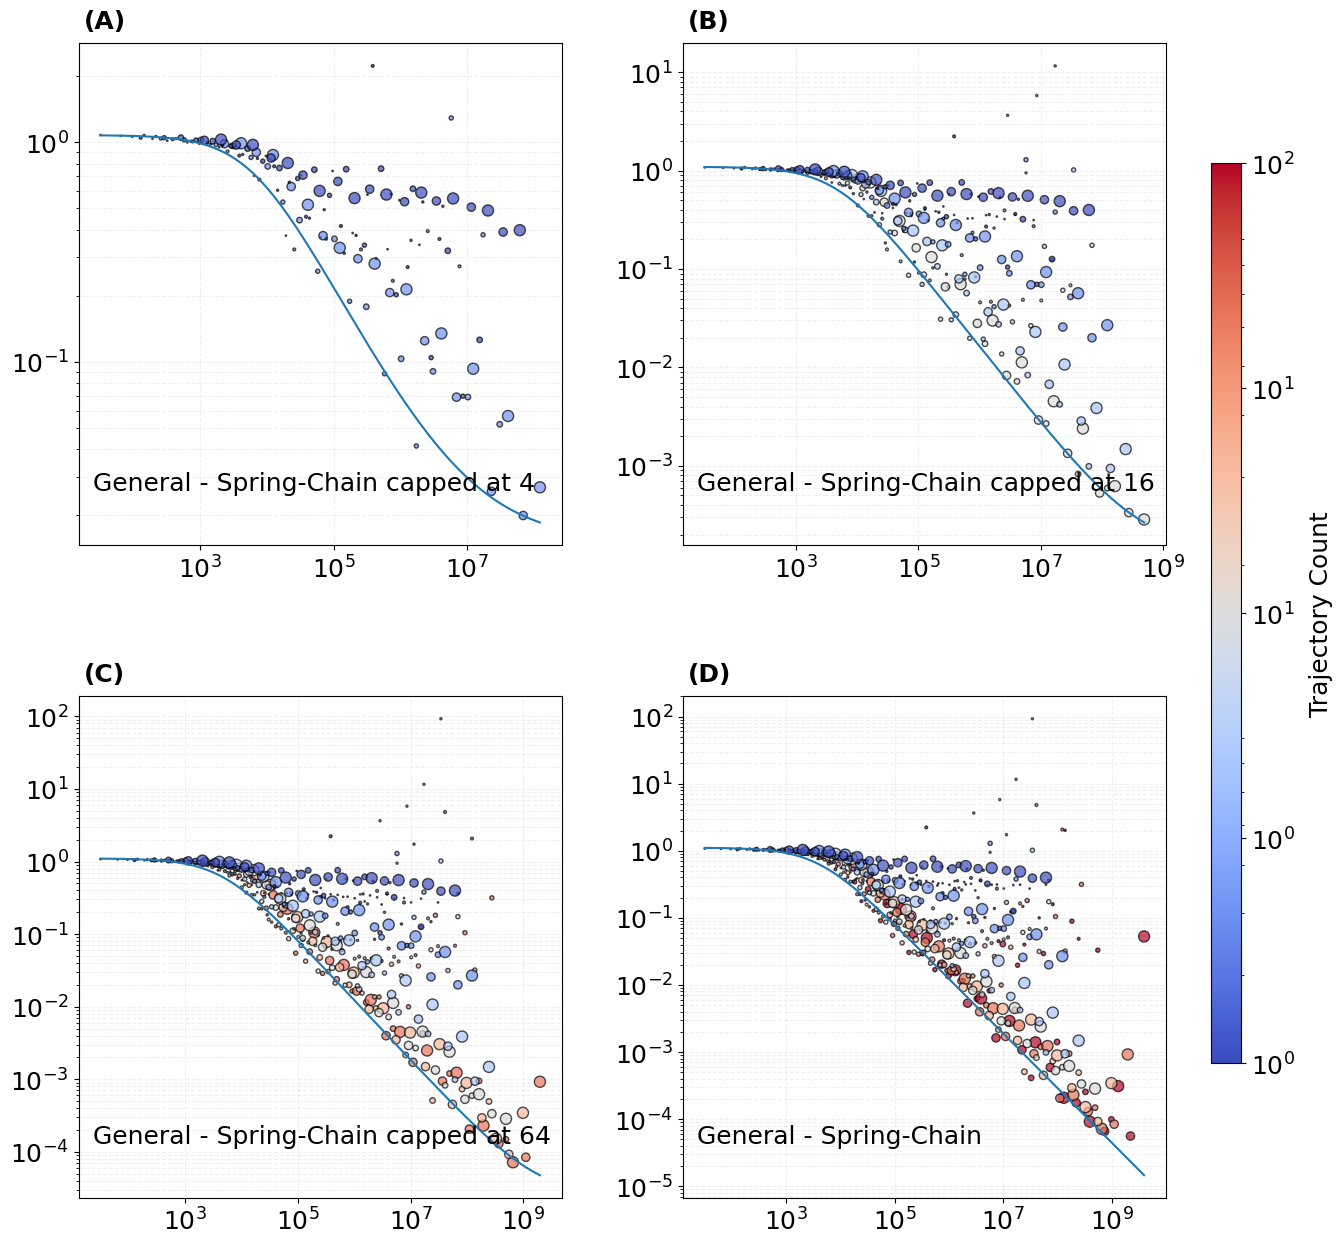

In [99]:
def mae_examples_nicer(data, mn, C, M, params, metric="mse"):
    all_trajectories = np.concatenate([
        data[f"traj_{mn[i][1]}_{mn[i][0]}"] for i in range(4)
    ])
    vmin, vmax = all_trajectories.min(), all_trajectories.max()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    fig.subplots_adjust(right=0.85, wspace=0.25, hspace=0.3)

    labels = list(string.ascii_uppercase)

    scatter_kwargs = dict(
        cmap='coolwarm',
        edgecolor='k',
        alpha=0.7,
        norm=LogNorm(vmin=vmin, vmax=vmax)
    )

    def sf(x):
        return f"{x:.2g}"

    def add_annotation(ax, title_str, formula_str):
        text_str = rf"{title_str}"
        ax.text(0.03, 0.1, text_str, transform=ax.transAxes,
                ha='left', va='bottom')
        #ax.text(0.03, 0.05, f"${formula_str}$", transform=ax.transAxes,
        #        ha='left', va='bottom', fontsize=9)

    for i in range(4):
        compute = data[f"compute_{mn[i][1]}_{mn[i][0]}"]
        mae = data[f"{metric}_{mn[i][1]}_{mn[i][0]}"]
        trajectories = data[f"traj_{mn[i][1]}_{mn[i][0]}"]
        sizes = data[f"sizes_{mn[i][1]}_{mn[i][0]}"]

        sc = axes[i].scatter(
            compute, mae,
            c=trajectories,
            s=(sizes ** 2) / 16,
            **scatter_kwargs
        )
        axes[i].plot(C[i], M[i])
        a, b, c_, d = params[i]
        formula = rf"f(C) = {sf(a)} + {sf(b)}(C + {sf(c_)})^{{{sf(d)}}}"
        add_annotation(axes[i], f"{MM[mn[i][1]]} - {DD[mn[i][0]]}", formula)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].grid(True, which='both', linestyle='--', alpha=0.2)
        axes[i].text(0.01, 1.02, f"({labels[i]})", transform=axes[i].transAxes,
                     ha='left', va='bottom', fontweight='bold')

    cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.6])
    sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label(r"Trajectory Count", labelpad=10)
    ticks = np.geomspace(vmin, vmax, num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([rf"$10^{{{int(np.log10(t))}}}$" for t in ticks])

    plt.savefig(f"figures/{metric}_examples.jpg", bbox_inches='tight')
mae_examples_nicer(data, [mn[10], mn[11], mn[12], mn[2]], [C_fits_mse[10], C_fits_mse[11], C_fits_mse[12], C_fits_mse[2]],
            [MS_fits[10], MS_fits[11], MS_fits[12], MS_fits[2]], [params_mses[10], params_mses[11], params_mses[12], params_mses[2]], metric="mse")


/tmp/ipykernel_3637884/1553408032.py:8: RuntimeWarning: divide by zero encountered in power
  e = (a + b * x**(-c0) * (1 + (x/d1)**(1/f1))**(-c1*f1))


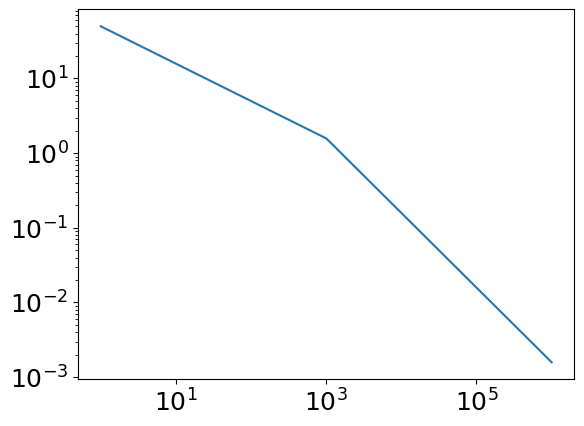

In [153]:
x = np.arange(10**6)
a = 0.
b = 50
c0 = 0.5
d1= 1000
f1 = 0.01
c1 = 0.5
e = (a + b * x**(-c0) * (1 + (x/d1)**(1/f1))**(-c1*f1))
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x, e)